# Info

[<img align="right" width="400" height="400" src="https://github.com/ML-IGP-TUBS-2025/Julian-Thoms/blob/master/Assignments/Assignment02_KNN/assets/TUBS_IGP_logo.jpg?raw=1">](https://www.tu-braunschweig.de/en/)

[Mehdi Maboudi](https://www.tu-braunschweig.de/en/igp/staff/mehdi-maboudi) ([m.maboudi@tu-bs.de](m.maboudi@tu-bs.de))

[Technical University of Braunschweig](https://www.tu-braunschweig.de/en/)  
[Institute of Geodesy and Photogrammetry](https://www.tu-braunschweig.de/igp)  


**k-Nearest Neighbor (kNN) exercise**  
Complete and hand in this worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission.

The kNN classifier consists of two stages:

During training, the classifier takes the training data and simply remembers it  
During testing, kNN classifies every test sample by comparing to all training samples and transfering the labels of the k most similar training examples  
The value of k is cross-validated  
In this exercise you will implement these steps and understand the basic classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.
***

In this exercise you will:
- get familiar with [**Iris dataset**](https://en.wikipedia.org/wiki/Iris_flower_data_set)
    
- implement a fully-vectorized **kNN**
- use a validation set to *tune the learning hyperparameter(s)*
- use cross validation to *tune the learning hyperparameter(s)*

# Setup

In [3]:
# Run some setup code for this notebook.
import numpy as np
import matplotlib.pyplot as plt
from os.path  import join
import pandas as pd


# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

seed = 57  # to make this notebook's output stable across runs

ModuleNotFoundError: No module named 'imp'

In [2]:
# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Data set

The famous [Iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set) first used in R.A. Fisher's classic 1936 paper, [The Use of Multiple Measurements in Taxonomic Problems](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1469-1809.1936.tb02137.x)  
and can also be found on the UCI Machine Learning [Repository](http://archive.ics.uci.edu/ml/index.php).


[SKlearn](https://scikit-learn.org/stable/datasets/index.html#iris-dataset)

In this dataset 4 charachteristics (features) of the 150 flowers (samples) are measured.  
There are 3 different classes of Iris (0 setosa, 1 versicolour, 2 virginica)  
Features include sepal lenght, sepal width, petal lenght, petal width.

## Loading Iris dataset

There are different possibilities for loading Iris dataset:
- from [source on web](http://archive.ics.uci.edu/ml/datasets/Iris)
- from a local .csv file
- from ML libraries like [scikit-learn](https://scikit-learn.org)
  or [seaborn](https://seaborn.pydata.org/index.html)

In [4]:
from sklearn.datasets import load_iris
'''
we can directly use the following line to load X,y of iris dataset
#X,y = load_iris(return_X_y=True)
instead we load iris dataset as a dataframe.
iris, and iris_df will be used just for explaining dataframe methods
They could also be used for visualizations.
For processing we will use just X,y as feature vectors a nd targets
'''
iris = load_iris(as_frame=True)
iris_df = iris.frame

X = iris.data.to_numpy()
y = iris.target.to_numpy()

## Visualize the dataset

In [5]:
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


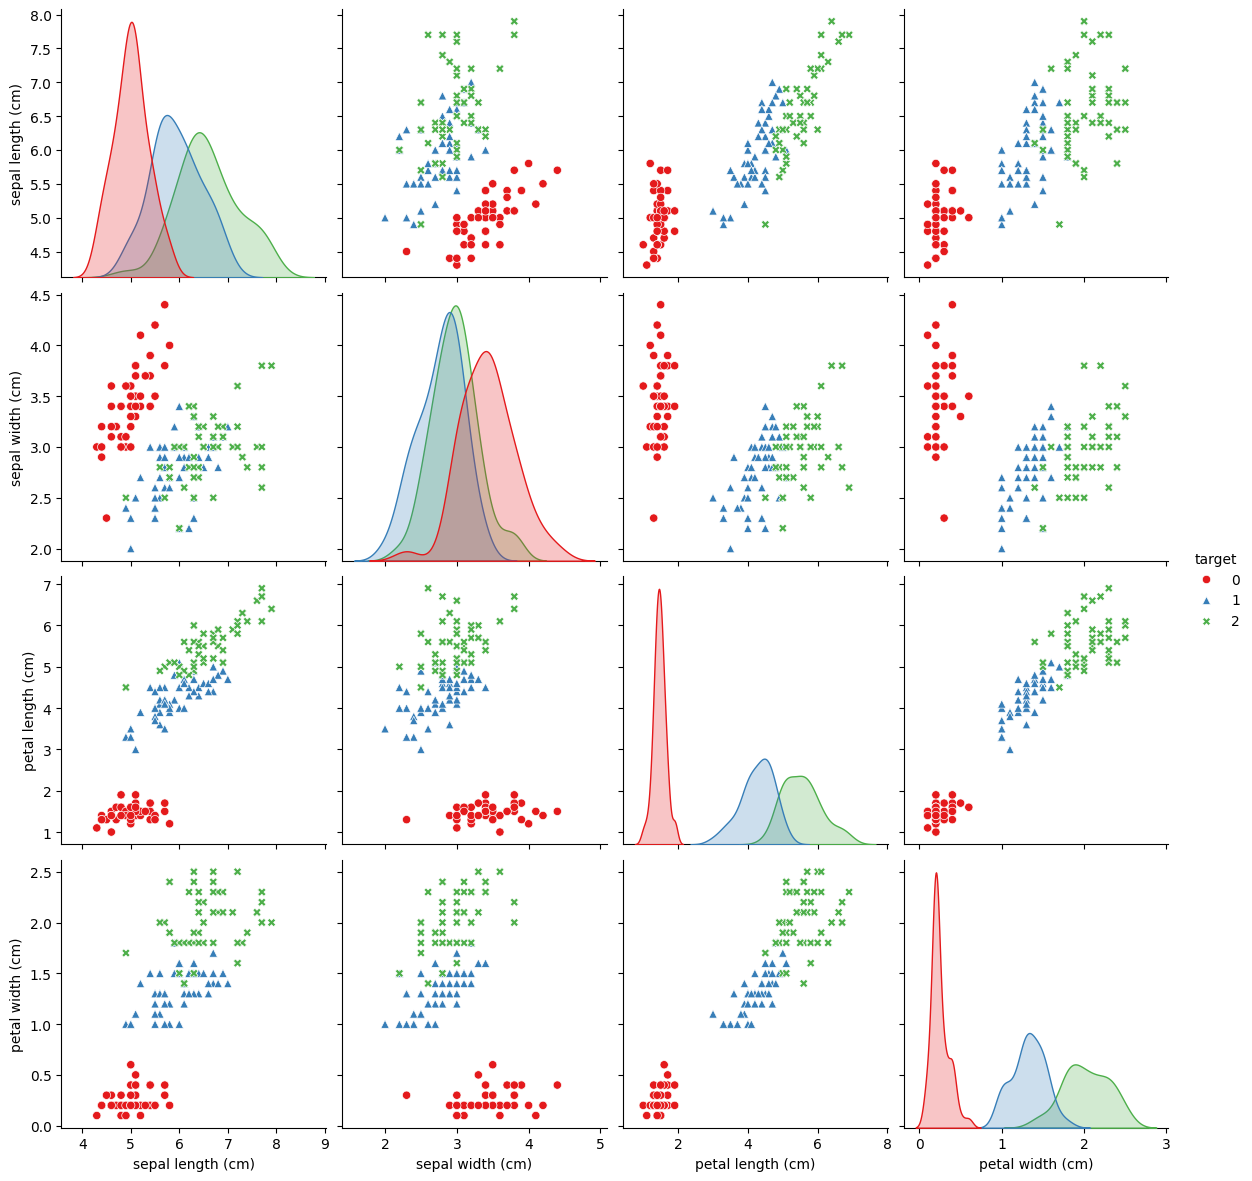

In [6]:
import seaborn as sns
sns.color_palette("hls", 8)

sns.pairplot(data=iris_df,
             hue="target",
             height = 3,
            markers=["o", "^", "X"],
            palette = "Set1")# or 'Set2' or 'pastel'

visible patterns in the dataset:
- We can see high correlation between petal_width and petal_height
- setosa is separable even just with a threshold on petal_width or height

$\color{blue}{\text{Do you see more patterns in the dataset?}}$  
<font color='red'>Your answer:
- Setosa ia also seperable by comparing petal_lenght with sepal_length or sepal_width
- Virginica and Versicolor are seperable by looking at the petal_width the best way</font>

## Data preparation and preprocessing

We need to split the dataset `(X,y)` to *trainSet* and *testSet*.     

We will use trainSet for our implementation.  
<font color='black'>The testSet should be held out for final evaluation</font>

But for hyperparameter tuning we need another set.  
So, after splitting our dataset into trainSet and testSet,  
we will further split the trainSet to two sets for training and validation

Scikitlearn has a function for this:
[sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)  
But, in this assignment you should write your own function using numpy and plain python

### Split data into train, and test set

Open `TUBS_1120019/data_utils.py` and implement the function `split_into_2_sets`

In [12]:
#from TUBS_1120019.data_utils import split_into_2_sets

# source
import numpy as np
seed=57

def split_into_2_sets(X,y,first_set_size=0.25,shuffle=True,random_state=seed):


    """
    Splits each of X,y input arrays to 2 separate arrays with the same orders

    Inputs:
      -X: A numpy array of shape (N, D)
      -y: A numpy array of shape (N,  )
      -first_set_size: (float or integer):
        when float [0,1): first set size will be an integer N*first_set_size
        when integer > 0: first set size will be first_set_size
      - shuffle: if True: in-place permutation of sets indices
      - random_state: initialize the pseudo-random number generator

    outputs:
      -X1: A numpy array of shape (N1_indices, D) which contains the first set  X
      -y1: A numpy array of shape (N1_indices,  ) which contains the first set  y
      -X2: A numpy array of shape (N2_indices, D) which contains the second set X
      -y2: A numpy array of shape (N2_indices,  ) which contains the second set y
    """
    assert X.shape[0]==y.shape[0]
    if  first_set_size<=0:
        raise ValueError('first_set_size should be greater then zero')

    N = X.shape[0]

       ### Start of your code ##

     #check other inputs to be valid
    if first_set_size >=1 and first_set_size <=100:
      first=int(first_set_size)
      if first>N:
        raise ValueError("first_set_size is bigger than the number of samples")
    else:
      first=int(N*first_set_size)

    ### End of your code ##

    ### Start of your code ##
     # separate X1,X2,y1,y2
    #shuffle

    rng = np.random.default_rng(random_state)

    indices = np.arange(N)
    if shuffle:
      indices = rng.permutation(indices)

    #indices = np.arange(N)
    #if shuffle:
        #np.random.seed(random_state)
        #np.random.shuffle(indices)

    X_shuffled = X[indices]
    y_shuffled = y[indices]

    # Split the data
    X1, X2 = X_shuffled[:first], X_shuffled[first:]
    y1, y2 = y_shuffled[:first], y_shuffled[first:]

    ### End of your code ##


    return X1, X2, y1, y2

X_trainSet, X_testSet, y_trainSet, y_testSet   = split_into_2_sets(X, y, first_set_size=0.8,shuffle=True, random_state=seed)

# As a sanity check of loading the dataset, we print out the size of the training and test data.
print('Training data shape: ', X_trainSet.shape,X_trainSet.dtype)
print('Training labels shape: ', y_trainSet.shape,y_trainSet.dtype)
print('Test data shape: ', X_testSet.shape,X_testSet.dtype)
print('Test labels shape: ', y_testSet.shape,y_testSet.dtype)





Training data shape:  (120, 4) float64
Training labels shape:  (120,) int64
Test data shape:  (30, 4) float64
Test labels shape:  (30,) int64


### Split the training data into train, and validation set

In [13]:
X_train, X_val, y_train, y_val   = split_into_2_sets(X_trainSet, y_trainSet, first_set_size=4/6,shuffle=False, random_state=seed)
X_test = X_testSet
y_test = y_testSet

In [14]:
# As a sanity check, we print out the size of the training, validation and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)

print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)

print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)


Training data shape:  (80, 4)
Training labels shape:  (80,)
Validation data shape:  (40, 4)
Validation labels shape:  (40,)
Test data shape:  (30, 4)
Test labels shape:  (30,)


**Note**:  
training proceeds on the training set, after which evaluation is done on the validation set,  
and when the experiment seems to be successful, final evaluation can be done on the test set.

Before starting any processing let's just do a random guess for the labels of the sample   
if we have K classes, the accuracy of the results should be around 1/K which in this case is 1/3

Using iris dataset and having a small training set, results are a bit different


In [15]:
K = np.max(y_trainSet)+1 # Number of classes
print('Number of classes: ', K)
y_train_predicted_random = np.random.randint(K,size=X_train.shape[0],dtype=int)
print("Accuracy of random classification: ",np.mean(y_train_predicted_random==y_train))

Number of classes:  3
Accuracy of random classification:  0.4


# kNN

## Training!

In [18]:
#from TUBS_1120019.classifiers import KNearestNeighbor
# Create a kNN classifier instance.
# Remember that training a kNN classifier is a noop:
# the Classifier simply remembers the data and does no further processing

import numpy as np

class KNearestNeighbor():
    """ a kNN classifier with L2 distance
        Our conventions:
            N: Number of trainig samples
            D: Dimensionality (Number of features)
    """

    def __init__(self):
        pass

    def train(self, X, y):
        """
        Train the classifier.
        For k-nearest neighbors this is just memorizing the training data.

        Inputs:
        - X: A numpy array of shape (N, D) containing the training data
          consisting of N samples each of dimension D.
        - y: A numpy array of shape (N,) containing the training labels, where
             y[i] is the label for X[i].
        """
        self.X_train = X
        self.y_train = y

    def predict(self, X, k=1, num_loops=0):
        """
        Predict labels for query data using this classifier.

        Inputs:
        - X: A numpy array of shape (Nq, D) containing query data consisting
             of Nq samples each of dimension D.
        - k: The number of nearest neighbors that vote for the predicted labels.
        - num_loops: Determines which implementation to use to compute distances
          between training points and query points.

        Returns:
        - y: A numpy array of shape (Nq,) containing predicted labels for the
          query data, where y[i] is the predicted label for the query sample X[i].
        """
        if num_loops == 0:
            dists = self.compute_distances_no_loops(X)
        elif num_loops == 1:
            dists = self.compute_distances_one_loop(X)
        elif num_loops == 2:
            dists = self.compute_distances_two_loops(X)
        else:
            raise ValueError('Invalid value %d for num_loops' % num_loops)

        return self.predict_labels(dists, k=k)

    def compute_distances_two_loops(self, X):
        """
        Compute the distance between each query point in X and each training point
        in self.X_train using a nested loop over both the training data and the
        query data.

        Inputs:
        - X: A numpy array of shape (Nq, D) containing query data.

        Returns:
        - dists: A numpy array of shape (Nq, N) where dists[i, j]
          is the Euclidean distance between the ith query point and the jth training
          point.
        """
        num_query = X.shape[0]  #Number of query samples: Nq
        num_train = self.X_train.shape[0]#Number of training samples: N
        dists = np.zeros((num_query, num_train))
        for i in range(num_query):
            for j in range(num_train):
                #####################################################################
                # TODO:                                                             #
                # Compute the l2 distance between the ith query point and the jth   #
                # training point, and store the result in dists[i, j]. You should   #
                # not use a loop over dimension, nor use np.linalg.norm().          #
                #####################################################################
                # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
                #Hier wird die Distanz von jedem Trainingspunkt zu jedem Testpunkt berechnet, Testpunkte i, Trainingspunkte j
                #Das ganze mit 2 Schleifen
                dists[i, j] = np.sqrt(np.sum((X[i] - self.X_train[j]) ** 2))


                # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return dists

    def compute_distances_one_loop(self, X):
        """
        Compute the distance between each query point in X and each training point
        in self.X_train using a single loop over the query data.

        Input / Output: Same as compute_distances_two_loops
        """
        num_query = X.shape[0]  #Number of query samples: Nq
        num_train = self.X_train.shape[0]#Number of training samples: N
        dists = np.zeros((num_query, num_train))
        for i in range(num_query):
            #######################################################################
            # TODO:                                                               #
            # Compute the l2 distance between the ith query point and all training#
            # points, and store the result in dists[i, :].                        #
            # Do not use np.linalg.norm().                                        #
            #######################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            # keine 2. SChleife, sondern direkt Distanzermittlung zu allen Trainigspunkten
            #spart Rechenzeit im Vergleich zu 1
            distance_between = self.X_train - X[i]
            dists[i, :] = np.sqrt(np.sum(distance_between**2, axis=1))

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return dists

    def compute_distances_no_loops(self, X):
        """
        Compute the distance between each query point in X and each training point
        in self.X_train using no explicit loops.

        Input / Output: Same as compute_distances_two_loops
        """
        num_query = X.shape[0]  #Number of query samples: Nq
        num_train = self.X_train.shape[0]#Number of training samples: N
        dists = np.zeros((num_query, num_train))
        #########################################################################
        # TODO:                                                                 #
        # Compute the l2 distance between all query points and all training     #
        # points without using any explicit loops, and store the result in      #
        # dists.                                                                #
        #                                                                       #
        # You should implement this function using only basic array operations; #
        # in particular you should not use functions from scipy,                #
        # nor use np.linalg.norm().                                             #
        #                                                                       #
        # HINT: Try to formulate the l2 distance using matrix multiplication    #
        #       and two broadcast sums.                                         #
        #########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        #noch einmal effizienter als Schleifen
        differences = X[:, np.newaxis, :] - self.X_train[np.newaxis, :, :]

        differences_squared = differences ** 2

        dist_squared = np.sum(differences_squared, axis=2)

        dists = np.sqrt(dist_squared)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return dists

    def predict_labels(self, dists, k=1):
        """
        Given a matrix of distances between query points and training points,
        predict a label for each query point.

        Inputs:
        - dists: A numpy array of shape (num_query, num_train) where dists[i, j]
          gives the distance betwen the ith query point and the jth training point.

        Returns:
        - y: A numpy array of shape (num_query,) containing predicted labels for the
          query data, where y[i] is the predicted label for the query point X[i].
        """
        num_query = dists.shape[0]#Number of query samples: Nq
        y_pred = np.zeros(num_query)#Speicherung der Vorhersagen für jeden query-Punkt
        for i in range(num_query):
            # A list of length k storing the labels of the k nearest neighbors to
            # the ith query point.
            closest_y = []
            #########################################################################
            # TODO:                                                                 #
            # Use the distance matrix to find the k nearest neighbors of the ith    #
            # query point, and use self.y_train to find the labels of these       #
            # neighbors. Store these labels in closest_y.                           #
            # Hint: Look up the function numpy.argsort.                             #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            #Sortierung der Distanzen je Zeile, d.h. je query-point, das ganze erfolgt bis zu unserem Wert für k
            sorted_indices = np.argsort(dists[i])[:k]

            #jetzt wollen wir die dazugehörigen labels bekommen
            closest_y = self.y_train[sorted_indices]

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


            #########################################################################
            # TODO:                                                                 #
            # Now that you have found the labels of the k nearest neighbors, you    #
            # need to find the most common label in the list closest_y of labels.   #
            # Store this label in y_pred[i]. Break ties by choosing the smaller     #
            # label.                                                                #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            #Jetzt: häufigstes Label finden
            counts = np.bincount(closest_y)

            #Auswählen des häufigsten labels
            y_pred[i] = np.min(np.where(counts == np.max(counts)))

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        return y_pred

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

## Prediction

After training! we would now like to predict the label of(classify) the `query data` with the kNN classifier.

Recall that we can break down this process into two steps:

1. First we must compute the distances between all query examples and all train examples.
2. Given these distances, for each query example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and query examples. For example, if there are **Ntr** training examples and **Nq** query examples, this stage should result in a **Nq x Ntr** matrix where each element (i,j) is the distance between the i-th query and j-th train example.

### Naive implementation

First, open `TUBS_1120019/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (query, train) examples and computes the distance matrix one element at a time.

Let's consider the validation set as query data to predict the labels of validation samples.

In [19]:
# Open TUBS_1120019/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists_val_2loops = classifier.compute_distances_two_loops(X_val)
print(dists_val_2loops.shape)

(40, 80)


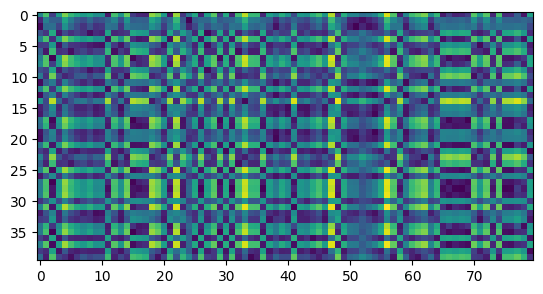

In [20]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists_val_2loops, interpolation='none')
plt.show()

In [21]:
# Using another dataset and having a lot of samples,
# if you run this cell (before implementing the function predict_labels),
# you will get the accuracy about 1/K where K is number of classes
# Using iris dataset and having a small training set, results are a bit different

# Implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_val_pred = classifier.predict_labels(dists_val_2loops, k=1)
num_val = y_val.shape[0]
# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_val_pred == y_val)
accuracy = float(num_correct) / num_val
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_val, accuracy))

Got 39 / 40 correct => accuracy: 0.975000


You should expect to see approximately `95%` accuracy. Now lets try out a larger `k`, say `k = 15`:

In [22]:
y_val_pred = classifier.predict_labels(dists_val_2loops, k=15)
num_val = y_val.shape[0]
# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_val == y_val_pred)
accuracy = float(num_correct) / num_val
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_val, accuracy))

Got 36 / 40 correct => accuracy: 0.900000


You should expect to see a 100% with `k = 15`.

### Semi-vectorized implementation

After ensuring that we have an implementation (which is too inefficient)
now we can improve our implementation. The main buttleneck is
distance matrix computation.
In this step we will implement a partial vectorized version with one loop.
Implement the function `compute_distances_one_loop` and run the code below:

In [23]:
dists_val_1loop = classifier.compute_distances_one_loop(X_val)

# To ensure that our semi-vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists_val_2loops - dists_val_1loop, ord='fro')
print('One loop difference is: %f' % (difference, ))
if difference < 1e-4:
    print('Good! The distance matrices are the same.')
else:
    print('The distance matrices are different. Check your code')

One loop difference is: 0.000000
Good! The distance matrices are the same.


### Vectorized implementation

In [24]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code below:
dists_val_vectorized = classifier.compute_distances_no_loops(X_val)

difference = np.linalg.norm(dists_val_2loops - dists_val_vectorized, ord='fro')
print('Vectorized version difference is: %f' % (difference, ))
if difference < 1e-4:
    print('Good! The distance matrices are the same.')
else:
    print('The distance matrices are different. Check your code')

Vectorized version difference is: 0.000000
Good! The distance matrices are the same.


## Validation

In [25]:
k_choices = sorted([1, 3, 5, 8, 10, 12, 15, 20, 50, 100])

# A dictionary holding the accuracies for different values of k that we find
# when running validation. After running validation, k_accuracies[k] should be
# a list giving the different accuracy values for different values of k.
k_accuracies = {}

################################################################################
# TODO:                                                                        #
# Perform validation to find the best value of k.                              #
# For each possible value of k,run the k-nearest-neighbor algorithm.           #
# Store the accuracies for values of k in the k_accuracies dictionary.         #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out the computed accuracies
for k in sorted(k_accuracies.keys()):
    print('k = %d, accuracy = %f' % (k, k_accuracies[k]))

In [ ]:
# plot the observations
plt.plot(*zip(*sorted(k_accuracies.items())))
plt.stem(*zip(*sorted(k_accuracies.items())),
         use_line_collection=True,
         bottom=plt.gca().get_ylim()[0],
         linefmt='y--',)
plt.title('Validation on k')
plt.xlabel('k')
plt.ylabel('Validation accuracy')
plt.xticks (k_choices)
plt.show()

In [ ]:
# Based on the validation results above, choose the best value for k
best_k_validation  =max(k_accuracies, key=k_accuracies.get)
print("Best k is:",best_k_validation)
print("validation accuracy:",k_accuracies[best_k_validation])

## Cross validation

By partitioning the available data into three sets (train,validation and test),  
we drastically reduce the number of samples which can be used for learning the model,  
and the results can depend on a particular random choice for the pair of (train, validation) sets.  

**A solution to this problem** is a procedure called **cross-validation** (CV for short).  
<font color='red'>The test set should still be held out for final evaluation</font>, but fixed validation set is no longer needed when doing CV.  

In the basic approach, called k-fold CV, the training set is split into k smaller sets.  
The following procedure is followed for each of the k “folds”:

- A model is trained using k-1 of the folds as training data;

- The resulting model is validated on the remaining part of the data (i.e., it is used to compute a performance measure such as accuracy).

The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop.  
This approach can be computationally expensive, but  
does not waste too much data (as is the case when fixing an arbitrary validation set),
which is a major advantage in problems **where the number of samples is very small**.


**Another benefit** of using cross validation is that:  
we can also compute the confidence interval of the estimated performance score (e.g. accuracy)

Let's also check cross validation for tuning the hyperparametrs.  
First we should combine training and validation set (Which we already splitted in two sets)

In [ ]:
X_tr = np.concatenate((X_train, X_val), axis=0)
y_tr = np.concatenate((y_train, y_val), axis=0)

# As a sanity check of loading the dataset, we print out the size of the training and test data.
print('Training data shape: ', X_tr.shape,X_tr.dtype)
print('Training labels shape: ', y_tr.shape,y_tr.dtype)

In [ ]:
# Provided as a reference. You may or may not want to change them
num_folds = 5
k_choices = sorted([1, 3, 5, 8, 10, 12, 15, 20, 50, 100])

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for k in k_choices:
    for f in range(num_folds):
        pass


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

In [ ]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [ ]:
# Based on the cross-validation results above, choose the best value for k
best_k_cross_validation = k_choices[np.argmax(accuracies_mean)]
print("Best k is:",best_k_cross_validation)
print("Cross validation accuracy:",np.max(accuracies_mean))

## Report the final results on test data

In [ ]:
# retrain the classifier using all the training data
classifier = KNearestNeighbor()
classifier.train(X_tr, y_tr)

In [ ]:
# predict the label of the test data and report it as your final result
# You should be able to get above 81% accuracy on the test data.
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

pass


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

num_test = X_test.shape[0]
# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) /num_test
print(f'Test set results(parameters tuned by {num_folds}-fold cross-validation):\
Got {num_correct:d} / {num_test:d} correct => accuracy: {accuracy:f}')

# let's check what happen with validation(instead of cross validation)
if best_k_cross_validation != best_k_validation:
    y_test_pred = classifier.predict(X_test, k=best_k_validation)
    # Compute and display the accuracy
    num_correct = np.sum(y_test_pred == y_test)
    accuracy = float(num_correct) /num_test
    print('Test set results(parameters tuned by              validation):'+\
          'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))
else:
    print('Got the same results using validation (NOT cross validation)')

If you reduce the number of training samples, you may see the different accuracy values!  

We can achieve more than 96%  test set accuracy on Iris dataset

*However:*
This is a simple dataset and we used it just to test our implementation
***

**Inline Questions**

Which of the following statements are true? Write your answer and explanation  
1. The decision boundary of the k-NN classifier is linear.  
$\color{blue}{\textit Your Answer:}$  
$\color{blue}{\textit Your Explanation:} $This statement is false most times because we generally have curved boundaries

2. The training error of a 1-NN will always be lower than that of 5-NN.  
$\color{blue}{\textit Your Answer:}$  
$\color{blue}{\textit Your Explanation: } $Because there is a majority vote for 5-NN, some training samples cannot be classified clearely.

3. The test error of a 1-NN will always be lower than that of a 5-NN.  
$\color{blue}{\textit Your Answer:}$  
$\color{blue}{\textit Your Explanation: }$I think it depends on the training data, but generally the fit might be better for k=5 because k=1 tends to overfitting.

4. The time needed to classify a test example with the k-NN classifier grows with the size of the training set.  
$\color{blue}{\textit Your Answer:}$  
$\color{blue}{\textit Your Explanation:}$

5. L2 distance always work better than L1 distance, but its computation cost is higher.  
$\color{blue}{\textit Your Answer:}$  
$\color{blue}{\textit Your Explanation: }$I am not sure whether L2-distance works better everytime, but its computation costs are definetely higher due to the square root etc.

6. Which part of kNN changes, if we do not set or change the random seed?  
$\color{blue}{\textit Your Answer:}$  
$\color{blue}{\textit Your Explanation:}$

***
**Select one of the topics below and implement it:**
- Visualize the decision boundary of kNN on iris dataset
- Check your implementation with scikitlearn      

## Visualize the decision boundary of kNN on iris dataset

Using the best selected hyperparameters, visualize the decision boundary of your kNN on iris data

## Check your implementation with scikitlearn

Use scikitlearn for solving iris classification problem

In [ ]:
from sklearn.datasets import load_iris
X,y = load_iris(return_X_y=True)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier